In [1]:
import numpy as np
import random
import itertools
from collections import defaultdict
import math
import os
from itertools import permutations
import time
from scipy.stats import mode
import re
import string
from unidecode import unidecode
import matplotlib.pyplot as plt

# L3

## Zadanie 1. (5p) 
W zadaniu tym masz napisać system, który bierze na wejściu (ztokenizowany) tekst w języku polskim, pozbawiony wielkich liter oraz polskich znaków diakrytycznych i wypisuje na wyjściu poprawny tekst w języku polskim. Zakładamy, że literka „ź” na wejściu jest reprezentowana przez „z” (a nie „x”). Liczymy dwie miary dokładności:
* Dokładność polskawa, czyli liczba słów poprawnie zrekonstruowanych (modulo wielkość liter, której nie uwzględniamy w tej mierze) podzielona przez liczbę słów w ogóle
* Dokładność pełna, czyli liczba słów poprawnie zrekonstruowanych podzielona przez liczbę słów (tu uwzględniamy zarówno ogonki jak i wielkość liter).

Ostatecznym wynikiem będzie średnia geometryczna tych liczb. W tym zadaniu sprawdzany jest
poziom basic, to znaczy że prezentowane rozwiązanie powinno:
* rekonstruować stokenizowany tekst,
* wykorzystywać dane dotyczące unigramów z części uczącej korpusu,
* w jakiś sposób (dowolny sensowny) uwzględniać informacje o dłuższych ciągach słów.

## Zadanie 2. (3 + Xp) 
W tym zadaniu rozwiązać należy dokładnie ten sam problem, co w poprzednim zadaniu. Żeby zadanie było uznane za zrobione poprawnie, wynik Twojego programu (na zbiorze ewaluacyjnym), musi być wyższy niż K = 0.955. Dodatkowo, jeżeli wynik R Twojego programu będzie większy niż Y = 0.96, to za zadanie dostaniesz $4*\frac{R-Y}{1-Y}$. Dodatkowa premia to 4 punkty za najlepszy program, 3 punkty za drugie miejsce, 2 punkty za trzecie i 1 punkt za czwarte (liczone we wszystkich grupach). Dozwolone jest korzystanie z korpusu PolEval (pierwszy milion wierszy), N-gramów NKJP oraz Morfologika. Zbiór testowy to kolejne 200 tysięcy wierszy korpusu PolEvala.

In [2]:
def get_acc(ans, org):
    l_org, l_ans = org.lower().split(), ans.lower().split()
    org, ans = org.split(), ans.split()
    polskawa_cnt, full_cnt, = 0,0
    for i, org_w in enumerate(org):
        polskawa_cnt += l_org[i] == l_ans[i]
        full_cnt += ans[i] == org_w
    #print(polskawa_cnt, full_cnt)
    #return polskawa_cnt/len(org)
    return ((polskawa_cnt*full_cnt)**0.5)/len(org)

In [4]:
train_data = []
test_data = []
with open('polish_corpora.txt', 'r', encoding='utf-8') as f:
    i = 0
    for line in f:
        i+=1
        if i <= 1000000:
            train_data.append(line[:-1])
        elif i <= 1200000:
            test_data.append(line[:-1])
        else:
            break

In [10]:
POLISH_FORMS = defaultdict(lambda: defaultdict(int))
BIGRAMS = defaultdict(lambda: defaultdict(int))
K = 1
with open('2grams', 'r', encoding='utf-8') as f:
    for line in f:
        c, w1, w2 = line[:-1].split()
        c, l_w1, l_w2 = int(c), w1.lower(), w2.lower()
        if c > K:
            POLISH_FORMS[unidecode(l_w1)][l_w1] += c//2
            POLISH_FORMS[unidecode(l_w2)][l_w2] += c//2
            BIGRAMS[l_w1][l_w2] += c

In [12]:
for sent in train_data:
    sent = sent.split()
    for i in range(len(sent)-1):
        w1, w2 = sent[i], sent[i+1]
        l_w1, l_w2 = w1.lower(), w2.lower()
        POLISH_FORMS[unidecode(l_w1)][l_w1] += 1
        BIGRAMS[l_w1][l_w2] += 1

In [13]:
CAPITAL_AFTER = defaultdict(lambda: 0)
CAPITAL_LETTERS = defaultdict(lambda: 0)
for sent in train_data:
    sent = sent.split()
    n = len(sent)
    for i in range(n-1):
        w = sent[i]
        if w[0].isalpha and w[0].isupper():
            CAPITAL_LETTERS[w.lower()] += 1
        else:
            CAPITAL_LETTERS[w.lower()] -= 1
        if sent[i+1][0].isalpha and sent[i+1][0].isupper():
            CAPITAL_AFTER[w.lower()] += 1
        else:
            CAPITAL_AFTER[w.lower()] -= 1

In [16]:
def reproduce(sent, K=1000, K2=10):
    sent = sent.split()
    all_options = [[[math.log(c/200000000),[org_w]] for org_w,c in POLISH_FORMS[w].items()] for w in sent]
    for i,l in enumerate(all_options):
        l.append([-20,[sent[i]]])
        l.sort(key = lambda e: e[0], reverse=True)
        l = l[:K2]
    
    curren_res = all_options[0]
    for i in range(1,len(sent)):
        next_res = []
        for c,l in curren_res:
            for c2,w in all_options[i]:
                w = w[0]
                l2 = l[:]
                l2.append(w)
                next_res.append([c+math.log((1+BIGRAMS[l[-1]][w])/200000000)+c2, l2])
        next_res.sort(key = lambda e: e[0], reverse=True)
        curren_res = next_res[:K]
    
    res = curren_res[0][1]
    for i,w in enumerate(res):
        if i==0 or CAPITAL_LETTERS[w]>0 or (i>0 and CAPITAL_AFTER[res[i-1].lower()]>0):
            res[i] = w.capitalize()
    return ' '.join(res)

In [171]:
# Poleval bigrams
tot_acc = 0.0
for i,test_s in enumerate(test_data):
    if i and not i%20000:
        print(f'{10*i/20000}%')
    decoded = unidecode(test_s).lower()
    reprocuded = reproduce(decoded,K=50)
    tot_acc += get_acc(reprocuded, test_s)
tot_acc/200000

10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


0.9639742377312832

In [17]:
# NKJP bigrams
tot_acc = 0.0
for i,test_s in enumerate(test_data):
    if i and not i%20000:
        print(f'{10*i/20000}%')
    decoded = unidecode(test_s).lower()
    reprocuded = reproduce(decoded,K=50)
    tot_acc += get_acc(reprocuded, test_s)
tot_acc/200000

10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


0.96073718952095

## Zadanie 3. (4p) 
W zadaniu tym zajmiemy się omawianym na wykładzie ukrytym łańcuchem Markowa, na przykładzie nieuczciwego krupiera rzucającego kością. Przypominam zasady:
1. Krupier ma dwie kości, uczciwą i oszukaną.
2. Kość oszukana daje 6 oczek z $p = \frac{1}{2}$, a pozostałe wyniki z $p = \frac{1}{10}$
3. Krupier zmienia kość uczciwą na nieuczciwą z $p1 = 0.04$, a nieuczciwą na uczciwą z $p2 = 0.05$
4. Zaczynamy od uczciwej kości.

Napisz program, który dla danego ciągu rzutów (który musisz sam wygenerować) wypisuje ciąg stanów (u – kość uczciwa, n – kość nieuczciwa, długość rzędu 10000), w sposób maksymalizujący liczbę prawidłowo zgadniętych stanów. Rozwiąż to zadanie na dwa sposoby:
* Proponując heurystyczny algorytm decydujący na podstawie badania skupisk szóstek
* Implementując poprawny algorytm, bazujący na zmiennych α oraz β (zobacz wykład o HMM).

Wykonując eksperymenty, oszacuj poprawność działania obu algorytmów, mierzoną liczbą poprawnie zgadniętych stanów (podzieloną przez długość ciągu).

In [20]:
def generate_data(N):
    D1 = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]
    D2 = [1/10, 1/10, 1/10, 1/10, 1/10, 1/2]
    Ds = [D1,D2]
    active_D = 0
    p1 = 0.04
    p2 = 0.05
    
    data = []
    D_history = []
    for i in range(N):
        data.append(np.random.choice(range(1,7), p=Ds[active_D]))
        D_history.append(active_D)
        if active_D==0:
            if random.random() < p1:
                active_D = 1
        else:
            if random.random() < p2:
                active_D = 0
    return data, D_history

In [35]:
def plot_data(data, hist):
    N = len(data)
    colors = ['Green' if not v else 'Red' for v in hist]
    f,axs = plt.subplots(2,1, figsize=(15,10))
    axs[0].bar(range(N),data)
    axs[1].bar(range(N),data,color=colors)
    plt.show()

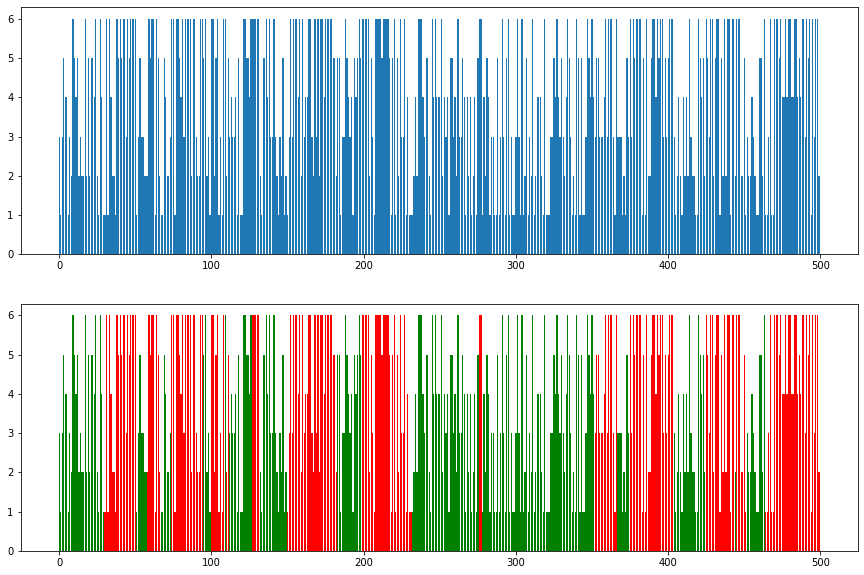

In [36]:
N = 500
data, hist = generate_data(N)
plot_data(data, hist)

In [64]:
def moving_average_classifier(data, d=10):
    ma = []
    data = np.array(data)
    for i in range(len(data)):
        ma.append(np.mean(data[max(0,i-d):i+d+1]))
    ma = np.array(ma)
    labels = ma>=4
    return labels

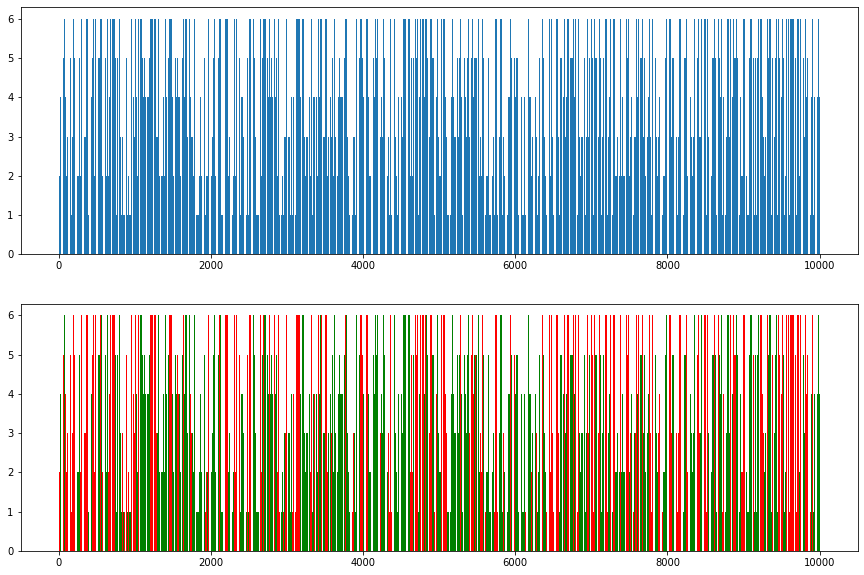

In [52]:
N = 10000
data, hist = generate_data(N)
plot_data(data, hist)

Heuristic method acc:  0.777


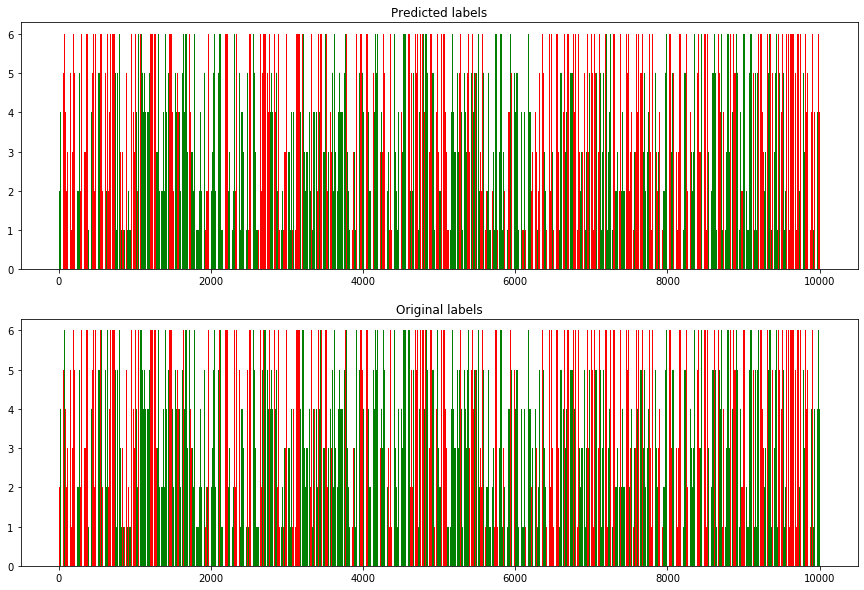

In [78]:
hist=np.array(hist)
mv_labels = moving_average_classifier(data, d=11)
print('Heuristic method acc: ',np.mean(mv_labels==hist))
pred_colors = ['Green' if not v else 'Red' for v in mv_labels]
N = len(data)
colors = ['Green' if not v else 'Red' for v in hist]
f,axs = plt.subplots(2,1, figsize=(15,10))
axs[0].bar(range(N),data,color=pred_colors)
axs[0].set_title('Predicted labels')
axs[1].bar(range(N),data,color=colors)
axs[1].set_title('Original labels')
plt.show()

In [214]:
def alpha_beta_classifier(data):
    N = len(data)
    alphas = np.zeros((2,N))
    betas = np.zeros((2,N))
    D1 = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]
    D2 = [1/10, 1/10, 1/10, 1/10, 1/10, 1/2]
    Ds = np.array([D1,D2])
    replacment_p = np.array([[0.96, 0.04], [0.05, 0.95]])
    
    for i in range(N):
        for j in range(2):
            if i==0:
                alphas[j,i] = j
            else:
                for k in range(2):
                    alphas[j,i] += alphas[k,i-1]*replacment_p[k,j]*Ds[k,data[i]-1]
                alphas[j,i] *= 6
    
    for i in range(N-1,-1,-1):
        for j in range(2):
            if i==N-1:
                betas[j,i] = 1
            else:
                for k in range(2):
                    betas[j,i] += betas[k,i+1]*replacment_p[j,k]*Ds[k,data[i]-1]
                betas[j,i] *= 6
    
    gammas = alphas * betas / np.sum(alphas * betas, axis=0)
    preds = np.argmax(gammas, axis=0)
    return preds 

Alpha-beta method acc:  0.8386


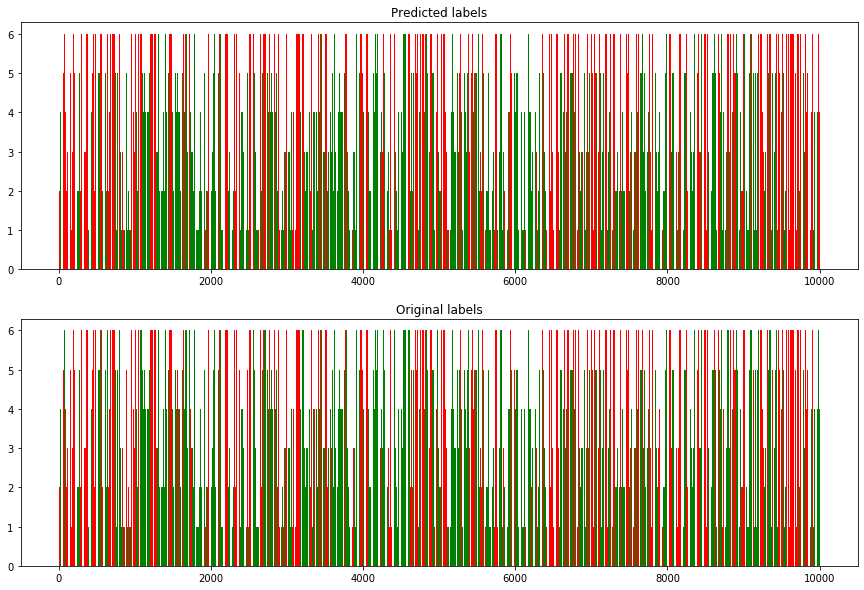

In [218]:
ab_preds = alpha_beta_classifier(data)
print('Alpha-beta method acc: ',np.mean(ab_preds==hist))
pred_colors = ['Green' if not v else 'Red' for v in ab_preds]
N = len(data)
colors = ['Green' if not v else 'Red' for v in hist]
f,axs = plt.subplots(2,1, figsize=(15,10))
axs[0].bar(range(N),data,color=pred_colors)
axs[0].set_title('Predicted labels')
axs[1].bar(range(N),data,color=colors)
axs[1].set_title('Original labels')
plt.show()